# Segmentation Algorithm Demo for CTNNB1

----------------------------------------
description of the structure 

----------------------------------------

Also, we may add a picture of the corresponding row in the lookup table for readers to correlate this notebook with a specifc row in the lookup table.


----------------------------------------
PLACEHOLDER: description of the functions to be used, and the usage of each parameters

----------------------------------------


In [107]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d, dot_slice_by_slice
#from aicssegmentation.core.vessel import vesselnessSliceBySlice
from aicssegmentation.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, boundary_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)
from aicssegmentation.core.visual import explore_vesselness_2d
from aicssegmentation.core.vessel import vesselnessSliceBySlice


## Loading the data

In [26]:
FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/CTNNB1/extra_evaluation/3500002055_100X_20180522_2r-Scene-04-P11-E05.czi'
reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 7, 65, 624, 924)


## Preview of the image

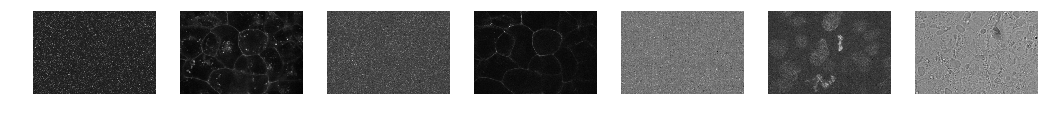

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

## Image segmentation

### Step 1: Pre-Processing

In [104]:
################################
## PARAMETERS for this step ##
structure_channel = 3
intensity_scaling_param = [4, 27]
gaussian_smoothing_sigma = 1
################################

structure_img0 = IMG[0,structure_channel,:,:,:]

# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = image_smoothing_gaussian_3d(structure_img, sigma=gaussian_smoothing_sigma)

intensity normalization: normalize into [mean - 4 x std, mean + 27 x std] 
intensity normalization completes


In [80]:
structure_img_smooth = boundary_preserving_smoothing_3d(structure_img)

In [14]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fa0e572b9…

#### If the contrast looks too off, you can play with the normalization parameters

In [28]:
from aicssegmentation.pre_processing_utils import suggest_normalization_param

In [29]:
suggest_normalization_param(structure_img0)

422.88459355815127
26.689644656012348
960.0
319
1145
suggested lower range is 20.5, which is 970.0223090064044
suggested upper range is 3.5, which is 329.47083726210803
So, suggested parameter for normalization is [3.5, 20.5]
You may also increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions) to further enhance the contrast


### Step 2: Core Algorithm

#### Run with default parameters as in Look-up Table

In [74]:
res2 = vesselnessSliceBySlice(structure_img_smooth, sigmas=[2],  tau=1, whiteonblack=True)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [76]:
view(segmentation_quick_view(res2>0.1))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff927df…

In [84]:
res = vesselnessSliceBySlice(structure_img_smooth, sigmas=[1],  tau=1, whiteonblack=True)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [93]:
view(segmentation_quick_view(res>0.06))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff95d2e…

In [105]:
################################
## PARAMETERS for this step ##
dot_3d_sigma = 1.5
dot_3d_cutoff = 0.03
################################

response2 = dot_3d(structure_img_smooth, log_sigma=dot_3d_sigma)
bw = response > dot_3d_cutoff

In [106]:
view(segmentation_quick_view(response2>0.03))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff95d2b…

In [115]:
response2d = dot_slice_by_slice(structure_img_smooth, log_sigma=1.5)

In [117]:
view(segmentation_quick_view(response2d>0.01))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff95d2b…

In [81]:
response1 = dot_3d(structure_img_smooth, log_sigma=0.75)

In [103]:
view(segmentation_quick_view(response1>0.0125))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff95d2f…

In [61]:
view(segmentation_quick_view(response1>0.007))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7ff976eb…

In [15]:
# Find a region of interest (ROI) in segmentation image above, and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [491,230, 757, 444]
view(seg_fluo_side_by_side(structure_img_smooth,bw,roi=ROI))

# or comment out the following line to see the whole FOV
#view(seg_fluo_side_by_side(structure_img,seg))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f7ae4bfe2…

#### If the segmentation is satisfactory, go to Step 3; otherwise, you can tune parameters to improve the performance. Follow the steps below:

--------------------------
Placeholder:  Describe the effect of each parameter

------------------------------

In [15]:
# find a small region of interest, 
# type in below the coordinates of upper left corner and lower right corner of the ROI
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [201, 139, 429, 345]
view(explore_vesselness_2d(structure_img_smooth, sigma=[1], th=0.15, roi=ROI))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fe92da939…

#### Now, if you have found a satisfatory set of parameters, type in the parameters below and re-run the segmentation. Then, move to step 3

In [17]:
# type in parameters here:
################################
## PARAMETERS for this step ##
vesselness_sigma = [0.5,2]
vesselness_cutoff = 0.15
################################

response = vesselness3D(structure_img_smooth, sigmas=vesselness_sigma,  tau=1, whiteonblack=True)
bw = response > vesselness_cutoff

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [19]:
################################
## PARAMETERS for this step ##
minArea = 4
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [17]:
view(seg_fluo_side_by_side(structure_img,SEG))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f2b44072c…

### You can also focus your inspection on a small ROI

In [ ]:
# Find ROI in segmentation image above (not the raw image on the right part), and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [244, 361, 441, 562]
view(seg_fluo_side_by_side(structure_img,SEG, roi=ROI))

### You may also physically save the segmentation results into a ome.tif file

In [27]:
SEG= SEG>0
out=SEG.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/DSP/test1.ome.tif')
writer.save(out)